# 1. 정형 데이터마이닝

####   1)  연관규칙 분석을 수행하기 위해 lotto 데이터셋을 transaction 데이터로 변환. (추첨된 순서는 고려하지 않음) 가장 많이 등장한 상위 10개의 로또번호를 막대그래프로 출력하고 이에 대해 설명하시오.       

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.preprocessing import TransactionEncoder

data = pd.read_csv("https://raw.githubusercontent.com/Yuvely/LottoProject/refs/heads/master/lotto.csv")
df = pd.DataFrame(data.iloc[:,:-1].values, columns=['num%s'%i for i in range(1,7)])

<Axes: >

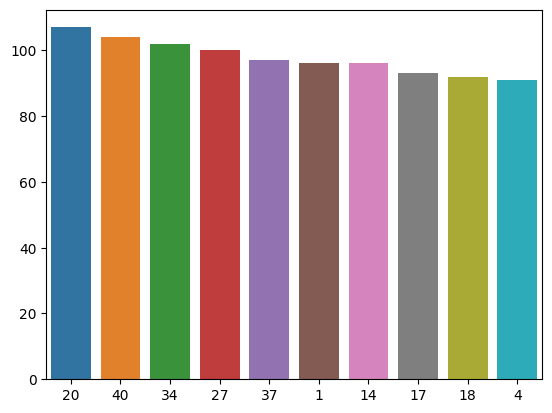

In [3]:

# 1. lotto 번호표를 Transaction encoding한다. ====================================
te = TransactionEncoder()
teary = te.fit_transform(df.values)

# true/false를 0/1로 변경 저장
df_tr = pd.DataFrame(teary, columns=te.columns_).applymap(lambda x: 1 if x else 0)

# 각 당첨번호 별 합계를 구하고 가장 많이 나온 10개를 담는다.
df_sum = df_tr.sum().sort_values(ascending=False)
df_sum10 = df_sum[:10,]

# 바그래프를 그리기 위해 df의 형태를 변경하고 plotting한다.
df_sum10 = pd.DataFrame(df_sum10.values.reshape(1,-1), columns=df_sum10.index)
sns.barplot(df_sum10)

# 설명
# 번호 중 가장 많이 출현한 숫자는 순서대로 20, 40, 34, 27, 37, 1, 14, 17, 8, 4와 같다.
# 당첨번호는 1~45 사이의 숫자로 결정이 되었는데, 가장 적게 출현한 경우 66, 가장 많이 출현한 경우는 107회 출현했고, 
# 평균 출현회수는 86회

In [94]:
df_sum.describe()

count     45.000000
mean      85.600000
std        8.674414
min       66.000000
25%       80.000000
50%       84.000000
75%       91.000000
max      107.000000
dtype: float64

####   2)  다음 조건을 반영하여 연관규칙을 생성하고 이를 'rule_1'이라는 변수에 저장하여 결과를 해석하시오. 그리고 도출된 연관규칙들을 향상도 기준으로 내림차순 정렬하여 상위 30개의 규칙을 확인하고, 이를 데이터프레임으로 변환하여 csv파일로 출력하시오.
- 최소 지지도 : 0.002
- 최소 신뢰도 : 0.8
- 최소조합 항목수 : 2개
- 최대조합 항목수 : 6개    
: association_rule에서 ante + cons를 2~6을 잡고 confidence의 최소를 0.8로 잡아 필터링한다.

In [10]:
# 최소지지도의 빈발집합 생성
from mlxtend.frequent_patterns import apriori
fset = apriori(df_tr, min_support=0.002, use_colnames=True, verbose=0)
fset.sort_values(by='support', ascending=False)

,support,itemsets
19,0.166667,(20)
39,0.161994,(40)
33,0.158879,(34)
26,0.155763,(27)
36,0.151090,(37)
...,...,...
2373,0.003115,"(8, 10, 23)"
2374,0.003115,"(24, 8, 10)"
2375,0.003115,"(8, 10, 27)"
2376,0.003115,"(8, 10, 34)"


In [55]:
# 최소신뢰도 및 최소/최대 항목수 반영
from mlxtend.frequent_patterns import association_rules

# metric={'support', 'confidence', 'lift', 'leverage', 'conviction'}
rule_1 = association_rules(fset, metric='confidence', min_threshold=0.8)
rule_1['ante_size'] = rule_1.antecedents.apply(lambda x: len(x))
rule_1['cons_size'] = rule_1.consequents.apply(lambda x: len(x))
rule_1['num_items'] = rule_1.ante_size + rule_1.cons_size

rule_save = rule_1.sort_values(by='lift', ascending=False).iloc[0:30,:]
rule_save.to_csv('D:\\python\\workspace\\material_ADP\\rule_1.csv', header=False)

In [56]:
rule_1.describe()

c:\Users\lsel\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,ante_size,cons_size,num_items
count,470.000000,470.000000,470.000000,470.0,470.000000,470.000000,470.0,470.000000,470.000000,470.000000,470.000000
mean,0.003165,0.134410,0.003165,1.0,8.181339,0.002739,inf,0.868338,3.029787,1.012766,4.042553
std,0.000274,0.018821,0.000274,0.0,7.060775,0.000240,NaN,0.018869,0.182280,0.112383,0.212353
min,0.003115,0.009346,0.003115,1.0,6.000000,0.002596,inf,0.835937,2.000000,1.000000,3.000000
25%,0.003115,0.126558,0.003115,1.0,6.978261,0.002669,NaN,0.859375,3.000000,1.000000,4.000000
50%,0.003115,0.130841,0.003115,1.0,7.642857,0.002708,NaN,0.871875,3.000000,1.000000,4.000000
75%,0.003115,0.143302,0.003115,1.0,7.901762,0.002727,NaN,0.876172,3.000000,1.000000,4.000000
max,0.004673,0.166667,0.004673,1.0,107.000000,0.004105,inf,0.993750,4.000000,2.000000,5.000000


In [63]:
rule_2 = rule_1.consequents.apply(set)
rule_2

0          {23}
1           {6}
2           {1}
3          {25}
4           {3}
         ...   
465        {27}
466        {14}
467        {40}
468    {27, 31}
469    {40, 30}
Name: consequents, Length: 470, dtype: object

In [64]:
rule_1[:3]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,ante_size,cons_size,num_items
0,"(24, 43)",(23),0.003115,0.124611,0.003115,1.0,8.025000,0.002727,inf,0.878125,2,1,3
1,"(16, 1, 2)",(6),0.003115,0.121495,0.003115,1.0,8.230769,0.002737,inf,0.881250,3,1,4
2,"(16, 2, 6)",(1),0.003115,0.149533,0.003115,1.0,6.687500,0.002649,inf,0.853125,3,1,4


In [66]:
rule_1['ante_list'] = rule_1.antecedents.apply(set)
rule_1['cons_list'] = rule_1.consequents.apply(set)
rule_1[:2]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,ante_size,cons_size,num_items,ante_list,cons_list
0,"(24, 43)",(23),0.003115,0.124611,0.003115,1.0,8.025000,0.002727,inf,0.878125,2,1,3,"{24, 43}",{23}
1,"(16, 1, 2)",(6),0.003115,0.121495,0.003115,1.0,8.230769,0.002737,inf,0.881250,3,1,4,"{16, 1, 2}",{6}


In [75]:
rule_1[rule_1.cons_list=={18}].shape

(20, 15)

:   전체 20개의 규칙이 도출되었으며, 이 중 (1, 11, 5)와 18이 함께 추첨될 확률은 지지도가 0.003115이며, 이는 약0.3%에 해당한다. 
    이 규칙의 향상도는 6.98로, 이는 18만 추첨됐을 때 보다 (1, 11, 5)이 뽑히고 18이 뽑힐 확률이 약 6배 높다는 것을 의미한다.
    하지만 이 규칙들은 단순히 조합에 대한 확률만을 고려하므로, 향상도가 높다는 것이 추첨번호로서의 의미를 갖는 것은 아니다.

# 2. 통계분석

####   1)  FIFA 데이터에서 각 선수의 키는 Height 변수에 피트와 인치로 입력되어 있습니다. 이를 cm으로 변환하여 새로운 변수 Height_cm을 생성하시오.    

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터를 읽어와 Height, Position, Value 열의 결측치를 제거한다.
data = pd.read_csv('https://raw.githubusercontent.com/blueage98/ML/main/fifa.csv', encoding='cp949')
df = data.dropna(subset=['Height', 'Position', 'Value'])

# 피트 단위 키를 Cm 단위로 변환하여 열을 추가한다.
def toCm(x):
    ht = x.split(sep="'")
    cm = int(ht[0])*30 + int(ht[1])*2.5
    return cm

df['Height_cm'] = df.Height.apply(lambda x: toCm(x))

df.head(2)

C:\Users\lsel\AppData\Local\Temp\ipykernel_24816\1024609184.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Height_cm'] = df.Height.apply(lambda x: toCm(x))


,Unnamed: 0,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,...,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,Release Clause,Height_cm
0,0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,...,Yes,RF,10.0,01-Jul-04,NaN,2021,5'7,159lbs,€226.5M,167.5
1,1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,...,Yes,ST,7.0,10-Jul-18,NaN,2022,6'2,183lbs,€127.1M,185.0


####   2)  포지션을 의미하는 Position 변수를 아래 표를 참고하여 'Forward', 'Midfielder', 'Defender', 'GoalKeeper'로 재범주화하고, factor형으로 변환하여 Position_Class라는 변수를 생성하고 저장하시오.

In [44]:
# Position 특성의 각 값들을 Forward/Midfielder/Defender/GoalKeeper로 분류하고, 
df['Position_Class'] = df.Position
df.Position_Class = df.Position_Class.apply(lambda x: 'Forward' if ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW'].__contains__(x) else x)
df.Position_Class = df.Position_Class.apply(lambda x: 'Midfielder' if ['LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM'].__contains__(x) else x)
df.Position_Class = df.Position_Class.apply(lambda x: 'Defender' if ['LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB'].__contains__(x) else x)
df.Position_Class = df.Position_Class.apply(lambda x: 'GoalKeeper' if x=='GK' else x)

print(df.Position_Class.info())
print(df.Position_Class.value_counts())


# 분류된 Position 값을 factor형으로 변환하여 Position_Class열에 저장한다.
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df.Position_Class = le.fit_transform(df.Position_Class)

print(le.classes_)
print(df.Position_Class.value_counts())

# 추후 분석을 위해 Value 열에 전처리
df.Value = df.Value.apply(lambda x: x.strip('€'))
df.Value = df.Value.apply(lambda x: x.strip('M'))
df.Value = df.Value.apply(lambda x: x.replace('K','000'))
df.Value = df.Value.astype(float)

<class 'pandas.core.series.Series'>
Index: 18147 entries, 0 to 18206
Series name: Position_Class
Non-Null Count  Dtype 
--------------  ----- 
18147 non-null  object
dtypes: object(1)
memory usage: 283.5+ KB
None
Position_Class
Defender      7305
Midfielder    5399
Forward       3418
GoalKeeper    2025
Name: count, dtype: int64
['Defender' 'Forward' 'GoalKeeper' 'Midfielder']
Position_Class
0    7305
3    5399
1    3418
2    2025
Name: count, dtype: int64


####   3)   새로 생성한 Position_Class 변수의 각 범주에 따른 Value 변수 평균값의 차이를 비교하는 일원배치 분산분석을 수행하고 결과를 해석하시오. (데이터는 등분산성을 만족하는 것으로 가정) 평균값의 차이가 통계적으로 유의하다면 사후검정을 수행하고 설명하시오.

In [52]:
df3 = df[['Position_Class', 'Value']]

df3.groupby('Position_Class').agg(['mean', 'var']).round(2)

Value              
                     mean           var
Position_Class                         
0               278574.68  8.501690e+10
1               259846.20  9.238496e+10
2               232433.45  6.155485e+10
3               254759.95  8.879440e+10

  stat: 15.954,  p-value: 0.000
statistic = 15.953594165202063
pvalue = 2.349781358686718e-10
df = (3.0, 18143.0)
df_num = 3.0
df_denom = 18143.0
nobs_t = 18147.0
n_groups = 4
means = [278574.68410678 259846.20002926 232433.45214815 254759.95288016]
nobs = [7305. 3418. 2025. 5399.]
vars_ = [8.50168972e+10 9.23849582e+10 6.15548532e+10 8.87943973e+10]
use_var = equal
welch_correction = True
tuple = (15.953594165202063, 2.349781358686718e-10)
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------
     0      1 -18728.4841 0.0104 -34243.5618  -3213.4064   True
     0      2  -46141.232    0.0 -64943.4956 -27338.9683   True
     0      3 -23814.7312    0.0 -37251.5175 -10377.9449   True
     1      2 -27412.7479 0.0044 -48407.5877  -6417.9081   True
     1      3  -5086.2471 0.8551 -21451.0082  11278.5139  False
     2      3  22326.5007 0.0173   2817.198

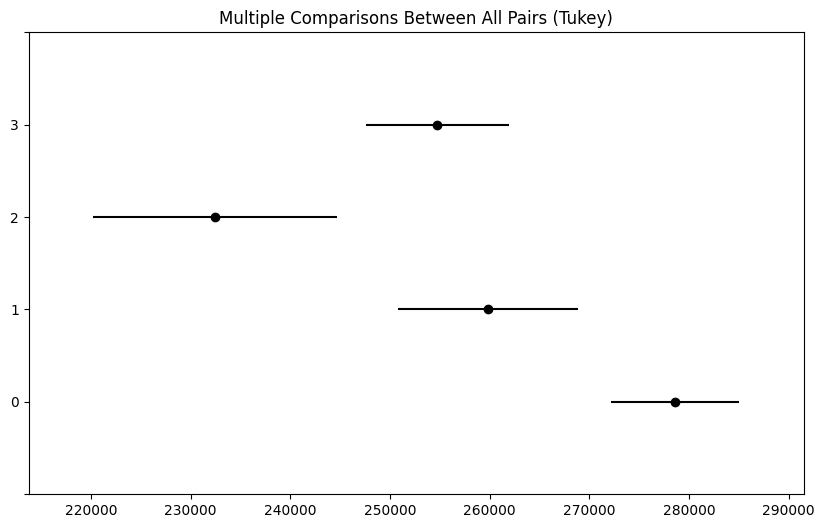

In [46]:
from statsmodels.stats.oneway import anova_oneway
oa = anova_oneway(data=df3['Value'], groups=df3['Position_Class'],use_var='equal')
print('  stat: {:.3f},  p-value: {:.3f}'.format(oa.statistic, oa.pvalue))
print(oa)

#사후검정 (정규성 O, 등분산 0, 샘플크기 다름)
from statsmodels.sandbox.stats.multicomp    import MultiComparison
from scipy.stats import ttest_ind
org_data = df3

mc = MultiComparison(data=org_data['Value'], groups=org_data['Position_Class']).tukeyhsd(alpha=0.05)
print(mc)

mc.plot_simultaneous()
plt.show()

####   4)   Preferred Foot과 Position_Class 변수에 따라 Value의 차이가 있는지를 알아보기 위해 이원배치 분산분석을 수행하고 결과를 해석하시오.

In [47]:
from pandas import DataFrame, crosstab

data = pd.DataFrame({   "A":[1,2,3,1,2,3,1,2,3,1,2,3],
                        "B":[1,1,1,2,2,2,3,3,3,4,4,4],
                        "Y": [4,3,5,5,7,6,7,8,9,8,10,12]})

print('데이터확인 \n', crosstab(data['A'], data['B'], values=data['Y'], aggfunc=list))

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols("Y~C(A)+C(B)", data = data).fit()
atable2 = anova_lm(model)
print('\n',atable2)

# A그룹 간에는 차이가 없고, B그룹 간에는 차이가 있는 것으로 나타났다.

데이터확인 
 B    1    2    3     4
A                     
1  [4]  [5]  [7]   [8]
2  [3]  [7]  [8]  [10]
3  [5]  [6]  [9]  [12]

            df  sum_sq  mean_sq     F    PR(>F)
C(A)      2.0     8.0      4.0   4.0  0.078717
C(B)      3.0    60.0     20.0  20.0  0.001586
Residual  6.0     6.0      1.0   NaN       NaN


In [55]:
df4 = df[['Position_Class', 'Preferred Foot', 'Value']]
df4.rename(columns={'Preferred Foot':'pref_foot'}, inplace=True)

le = LabelEncoder()
df4['pref_foot'] = le.fit_transform(df4['pref_foot'])


from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('Value~C(Position_Class)+C(pref_foot)+C(Position_Class):C(pref_foot)', data=df4).fit()
atable = anova_lm(model)
print(atable)

# pref_foot 에 따른 Value의 차이는 지지되지 않지만, Position에 따른 차이는 있는 것으로 드러난다.

#

C:\Users\lsel\AppData\Local\Temp\ipykernel_24816\2358598366.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4.rename(columns={'Preferred Foot':'pref_foot'}, inplace=True)
C:\Users\lsel\AppData\Local\Temp\ipykernel_24816\2358598366.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['pref_foot'] = le.fit_transform(df4['pref_foot'])


                                     df        sum_sq       mean_sq  \
C(Position_Class)                   3.0  4.063911e+12  1.354637e+12   
C(pref_foot)                        1.0  9.092730e+10  9.092730e+10   
C(Position_Class):C(pref_foot)      3.0  5.375961e+11  1.791987e+11   
Residual                        18139.0  1.539913e+15  8.489517e+10   

                                        F        PR(>F)  
C(Position_Class)               15.956587  2.339510e-10  
C(pref_foot)                     1.071054  3.007213e-01  
C(Position_Class):C(pref_foot)   2.110823  9.654828e-02  
Residual                              NaN           NaN  


####   5)   Age, Overall, Wage, Height_cm, Weight_lb가 Value에 영향을 미치는지 알아보는 회귀분석을 단계적 선택법을 사용하겨 수행하고 결과를 해석하시오.

- 변수 선택법의 종류
    - 단계적 방법 (Stepwise method)
    - 전진 선택법 (Forward Selection)
    - 후진 제거법 (Backward elimination)
- 변수 선택 시 사용되는 측도
    - Adjusted R squared
        - 모델에 변수를 추가할수록 기존의 결정계수에 불이익을 주며, 모형의 적합도를 판단하는 척도
    - AIC (Akaike's information criteria)
        - 모델에 변ㅅ두를 추가할수록 불이익을 주는 오차 측벙법
    - BIC (Bayesial information criteria)
        - AIC와 유사하나 변수 추가에 더 강한 벌점을 준다.
    - Mallow Cp    

In [94]:
df5 = df[['Age', 'Overall', 'Wage', 'Height_cm', 'Weight', 'Value']].copy()

df5.Wage = df5.Wage.apply(lambda x: x.strip('€'))
df5.Wage = df5.Wage.apply(lambda x: x.strip('M'))
df5.Wage = df5.Wage.apply(lambda x: x.replace('K','000'))
df5.Wage = df5.Wage.astype(float)

df5.Weight = df5.Weight.apply(lambda x: x.strip('lbs'))
df5.Weight = df5.Weight.astype(float)

df5.head(3)

,Age,Overall,Wage,Height_cm,Weight,Value
0,31,94,565000.0,167.5,159.0,110.5
1,33,94,405000.0,185.0,183.0,77.0
2,26,92,290000.0,172.5,150.0,118.5


In [87]:
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
import numpy as np

from sklearn.datasets import load_diabetes

def stepwise_method(X, y):
    result = pd.DataFrame()
    feature_combis = []
    for i in range(1, len(X.columns)+1):
        feature_combis += list(combinations(X.columns, i))
    feature_combis.reverse()
    
    for j, feature_combi in enumerate(feature_combis):
        X_ = X.filter(feature_combi)
        X_ = sm.add_constant(X_)
        
        model = sm.OLS(y, X_)
        fitted = model.fit()

        n = fitted.nobs     # number of observation
        p = fitted.df_model # 설명변수의 개수
        if j==0:
            MSE_full = fitted.mse_resid     #full 모델의 MSE

        result.loc[j, 'feature_combi'] = ', '.join(list(fitted.params.keys()))
        result.loc[j, 'AIC'] = fitted.aic

        result = result.sort_values(by='AIC', ascending=True)   #AIC/BIC는 낮을수록, adj_R2는 높을수록 좋아.
        best = result.iloc[0,0]
    return best, result


data = load_diabetes()
Xa = data.data
ya = data.target

diabetes = pd.DataFrame(data=data.data, columns=data.feature_names)
diabetes['target'] = data.target

X = diabetes[['age','sex','bmi','bp']]
y = diabetes.target

best, result = stepwise_method(X, y)

print('최적 변수조합 : ', best)
print('전체 결과값\n', result)

최적 변수조합 :  const, sex, bmi, bp
전체 결과값
                feature_combi          AIC
1        const, sex, bmi, bp  4876.695451
5             const, bmi, bp  4877.487843
0   const, age, sex, bmi, bp  4878.354373
2        const, age, bmi, bp  4879.321047
9            const, age, bmi  4909.624337
4       const, age, sex, bmi  4911.296550
12                const, bmi  4912.038221
7            const, sex, bmi  4913.987529
6             const, sex, bp  5002.163006
11                 const, bp  5002.507604
3        const, age, sex, bp  5002.828421
8             const, age, bp  5003.526444
14                const, age  5082.445976
10           const, age, sex  5084.394690
13                const, sex  5097.511242


In [100]:
# 데이터를 전처리한다.
from sklearn.preprocessing import StandardScaler

X = df5[['Age', 'Overall', 'Wage', 'Height_cm', 'Weight']].copy()
y = df5.Value.values

scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

# 변수 선택법을 수행한다.
stepwise_method(X, y)   #수행결과 'Age', 'Overall', 'Wage'가 선택된다.

('const, Age, Overall, Wage',
                                    feature_combi            AIC
 15                     const, Age, Overall, Wage  506621.042881
 4              const, Age, Overall, Wage, Weight  506622.326809
 0   const, Age, Overall, Wage, Height_cm, Weight  506622.940799
 5           const, Age, Overall, Wage, Height_cm  506623.027894
 1        const, Overall, Wage, Height_cm, Weight  506658.112489
 8                   const, Overall, Wage, Weight  506659.273493
 21                          const, Overall, Wage  506661.267163
 9                const, Overall, Wage, Height_cm  506663.138989
 24                              const, Age, Wage  506918.972946
 28                                   const, Wage  506919.675668
 12                   const, Age, Wage, Height_cm  506920.970704
 11                      const, Age, Wage, Weight  506920.972331
 17                           const, Wage, Weight  506921.557495
 18                        const, Wage, Height_cm  506921.64

In [110]:
# 선택된 변수로 회귀분석을 수행한다.
from sklearn.linear_model import LinearRegression

X = df5[['Age', 'Overall', 'Wage']].copy()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

X_ = sm.add_constant(X)
model = sm.OLS(y, X_)
fitted = model.fit()


fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     556.2
Date:                Tue, 08 Oct 2024   Prob (F-statistic):               0.00
Time:                        01:04:56   Log-Likelihood:            -2.5331e+05
No. Observations:               18147   AIC:                         5.066e+05
Df Residuals:                   18143   BIC:                         5.067e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.628e+05   2072.749    126.794      0.000    2.59e+05    2.67e+05
Age         1.532e+04   2356.180      6.501      0.000    1.07e+04    1.99e+04
Overall    -4.944e+04   2843.097    -17.388      0.000    -5.5e+04   -4.39e+04
Wage       -5.044e+04   2559.903    -19.703      0.000   -5.55e+04   -4.54e+04
==============================================================================
Omnibus:                     2033.483   Durbin-Watson:                   1.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2725.425
Skew:                           0.939   Prob(JB):                         0.00
Kurtosis:                       2.719   Cond. No.                         2.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
lr = LinearRegression()
lr.fit(X, y)
pred = lr.predict(X)

print('회귀계수: ', lr.coef_)
print('절편: ', lr.intercept_)
print('결정계수: {:.3f}'.format(lr.score(X,y)))



회귀계수:  [ 15317.73271177 -49436.85377032 -50437.47720566]
절편:  262813.08785474184
결정계수: 0.084


# 3. 비정형 텍스트마이닝

####   1)   "영화 기생충_review.txt" 데이터를 읽어온 뒤, 숫자, 문자, 특수문자 등을 제거하는 전처리 작업을 시행하시오. 그리고 '영화 기생충_review.txt'를 사전에 등록하시오.

In [2]:
import pandas as pd
import re

#파일이 읽혀지지 않는다면, 첫번째 encoding문자, 그리고 깨진 문자 때문일 수 있으니 위치를 찾아야 한다. 그리고 
data = pd.read_csv("D:\python\workspace\material_ADP\영화_기생충_review.txt", encoding='cp949', header=None, engine='python', sep='\r\n')

# 특수문자 제거
data.iloc[:,0] = data.iloc[:,0].apply(lambda x: re.sub(r"[^\uAC00-\uD7A3a-zA-Z\s]", " ", x)).copy()      #한글/영문/숫자가 아닌 것을 지워라.

In [93]:
# =============================================================
# 방식 1.   CountVectorizer를 써서 빈도 매트릭스를 만들고 sum하는 방식
#           이 방식의 문제는 명사 단위 추출이 안된다는 것
# =============================================================
from sklearn.feature_extraction.text import CountVectorizer

vector = CountVectorizer()
cv_fit = vector.fit_transform(data.values.ravel().tolist())

#cv_fit.toarray()       # 단어의 출현 매트릭스
#vector.vocabulary_     # 단어,인덱스 목록
word_list = vector.get_feature_names_out()  # 전체 단어의 리스트
count_list = cv_fit.toarray().sum(axis=0)   # 각 단어의 출현 빈도

df_vect = pd.DataFrame(cv_fit.todense(), columns=word_list)
df_count = pd.DataFrame(df_vect.sum().sort_values(ascending=False))
df_count.columns = ['freq']

# dictionary로 만들고 싶을 때
dic = dict(zip(word_list, count_list))

In [116]:
# =============================================================
# 방식 2.   konlpy를 사용하는 방식. 복잡하지만 명사 등 품사별 추출이 된다. 
#           이 방식의 문제는 형용사에 섞인 명사를 잘 식별하지 못한다는 점이다. 
#           '불편'은 명사로 잡지만 '불편한데'의 불편은 명사로 잡지 않는다.
# =============================================================

from konlpy.tag import Okt
from collections import Counter

joined_str = " ".join(data.values.ravel().tolist())

okt = Okt()
noun = okt.nouns(joined_str)
morph = okt.morphs(joined_str)

noun_count = Counter(noun)
morph_count = Counter(morph)

#명사 빈도 카운트
noun_list = noun_count.most_common()
morph_list = morph_count.most_common()

df_count = pd.DataFrame(noun_list)
df_count = df_count.set_index(0)
df_count.columns = ['freq']

# dictionary로 만들고 싶을 때
dic = dict(noun_list)


     freq
0        
봉준호   138
기생충    78
송강호    60
이선균    28
조여정    26
최우식    12
이정은    11
기우      3
기택      1
기정      1
장혜진     1


<Axes: xlabel='0'>

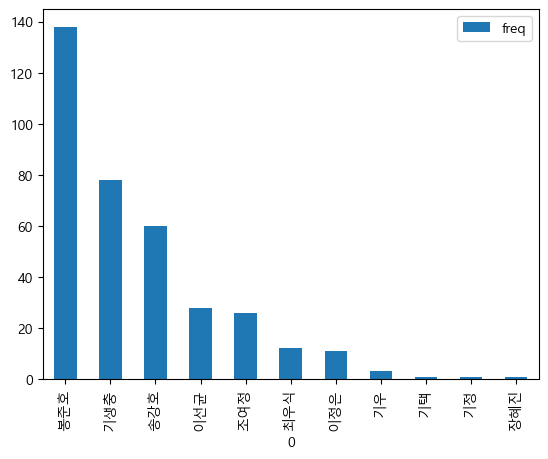

In [99]:
# 관심있는 단어의 목록을 읽어온다.
import matplotlib.pyplot as plt
worddf = pd.read_csv("D:\python\workspace\material_ADP\영화_기생충_사전.txt", encoding='cp949', header=None)
wordlist = worddf.values.ravel().tolist()

# 빈도테이블에서 관심단어의 목록만 추출해서 exists에 저장한다.
#exists = pd.DataFrame(df_count.columns)

wordlist2 = wordlist.copy()

for i in range(0, len(wordlist)):
    if wordlist[i] not in df_count.index :
        wordlist2.remove(wordlist[i])

exists = df_count.loc[wordlist2,:]

# exists 목록을 정렬하고,
exists = exists.sort_values(by='freq', ascending=False)

# 데이터프레임으로 만들어 플로팅
retdf = pd.DataFrame()
retdf.index = exists.index
retdf['freq'] = exists

plt.rcParams['font.family'] = 'Malgun Gothic'
retdf.plot(kind='bar', y='freq', legend=True)

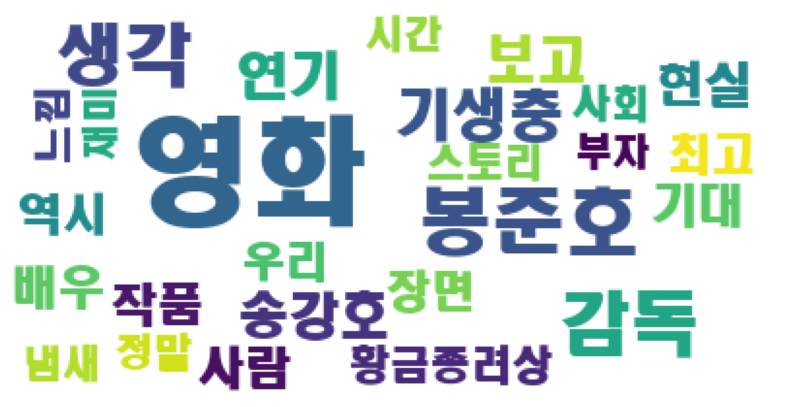

In [103]:
from wordcloud import WordCloud

digest = dict()
for i in dic:
    if len(i) >1 and dic[i] > 30:
        digest[i] = dic[i]

wc = WordCloud(font_path='C://Windows//Fonts//HMKMRHD.ttf', background_color="white", max_font_size=60)
cloud = wc.generate_from_frequencies(digest)

plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(cloud)
plt.show()